# Análisis de Clientes con Lifetimes: Modelos Buy Till You Die

## 📊 Guía Didáctica Completa

Este notebook te enseñará a usar la librería `lifetimes` para analizar el comportamiento de clientes y predecir:
- **¿Qué clientes están "vivos" vs "muertos"?**
- **¿Cuántas compras futuras realizará cada cliente?**
- **¿Cuál es el valor de vida del cliente (CLV)?**

### 🎯 Objetivos de Aprendizaje
1. Entender los modelos BG/NBD y Gamma-Gamma
2. Preparar datos para análisis BTYD (Buy Till You Die)
3. Ajustar modelos y interpretar parámetros
4. Realizar predicciones y calcular CLV
5. Visualizar y validar resultados

---

## 1. 📦 Instalación y Carga de las librerías

Primero instalamos las librerías necesarias:

In [16]:
!uv pip install pandas
!uv pip install numpy
!uv pip install matplotlib
!uv pip install seaborn
!uv pip install plotly
!uv pip install lifetimes
!uv pip install duckdb
!uv pip install sklearn

Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 5ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 5ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 6ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 5ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 5ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 4ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
Audited 1 package in 3ms
Using Python 3.12.11 environment at: /media/ssd512/home/karel/projects/usa/psm/dashboards/.venv
  × Failed to build `sklearn==0.0.post12`                

In [4]:
# Instalar librerías (ejecutar solo si es necesario)
# !pip install lifetimes pandas numpy matplotlib seaborn plotly

# Importar librerías
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Librerías de lifetimes
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from lifetimes.generate_data import beta_geometric_nbd_model

# Configuración de plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. 📊 Generación de Datos Sintéticos

Vamos a generar datos sintéticos que simulan el comportamiento real de una empresa e-commerce:

In [5]:
# Configurar semilla para reproducibilidad
np.random.seed(42)

# Generar datos sintéticos de transacciones
def generate_transaction_data(n_customers=2000, start_date='2022-01-01', end_date='2023-12-31'):
    """
    Genera datos sintéticos de transacciones para análisis BTYD
    """
    transactions = []
    
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    for customer_id in range(1, n_customers + 1):
        # Parámetros aleatorios para cada cliente
        # Frecuencia de compra (lambda) - más alta = más activo
        purchase_rate = np.random.gamma(0.5, 2)
        
        # Probabilidad de "muerte" (dropout)
        dropout_prob = np.random.beta(1, 10)
        
        # Valor monetario promedio
        avg_monetary = np.random.lognormal(3, 0.5)
        
        current_date = start
        is_alive = True
        
        # Primera compra (todos los clientes tienen al menos una)
        first_purchase_days = np.random.exponential(30)
        purchase_date = start + timedelta(days=min(first_purchase_days, (end-start).days))
        
        if purchase_date <= end:
            monetary_value = np.random.lognormal(np.log(avg_monetary), 0.3)
            transactions.append({
                'customer_id': f'C{customer_id:04d}',
                'transaction_date': purchase_date,
                'monetary_value': round(monetary_value, 2)
            })
            
            current_date = purchase_date
        
        # Compras subsecuentes
        while current_date < end and is_alive:
            # Tiempo hasta siguiente compra
            days_to_next = np.random.exponential(1/purchase_rate * 30)  # Convertir a días
            
            # Check si el cliente "muere" antes de la siguiente compra
            if np.random.random() < dropout_prob * (days_to_next / 365):
                is_alive = False
                break
            
            next_date = current_date + timedelta(days=days_to_next)
            
            if next_date <= end:
                monetary_value = np.random.lognormal(np.log(avg_monetary), 0.3)
                transactions.append({
                    'customer_id': f'C{customer_id:04d}',
                    'transaction_date': next_date,
                    'monetary_value': round(monetary_value, 2)
                })
                current_date = next_date
            else:
                break
    
    return pd.DataFrame(transactions)

# Generar el dataset
df_transactions = generate_transaction_data(n_customers=2000)

print(f"📈 Dataset generado con {len(df_transactions):,} transacciones")
print(f"👥 Número de clientes únicos: {df_transactions['customer_id'].nunique():,}")
print(f"📅 Período: {df_transactions['transaction_date'].min().strftime('%Y-%m-%d')} a {df_transactions['transaction_date'].max().strftime('%Y-%m-%d')}")
print(f"💰 Valor total: ${df_transactions['monetary_value'].sum():,.2f}")

# Mostrar primeras filas
df_transactions.head(10)

📈 Dataset generado con 43,885 transacciones
👥 Número de clientes únicos: 2,000
📅 Período: 2022-01-01 a 2023-12-30
💰 Valor total: $1,039,747.14


,customer_id,transaction_date,monetary_value
0,C0001,2022-01-02 19:05:02.088234,25.61
1,C0002,2022-01-23 07:37:40.937591,11.44
2,C0002,2022-01-25 15:43:02.447069,11.14
3,C0002,2022-01-27 01:59:06.622169,16.59
4,C0002,2022-01-29 14:22:42.983658,15.40
5,C0002,2022-02-02 07:23:31.489575,9.84
6,C0002,2022-02-06 04:09:26.355645,12.61
7,C0002,2022-02-10 22:29:08.881017,13.83
8,C0002,2022-02-11 11:23:38.930614,19.32
9,C0002,2022-02-13 00:26:31.425644,10.47


## 3. 🔍 Análisis Exploratorio de Datos

Antes de modelar, exploremos nuestros datos:

In [6]:
# Estadísticas básicas
print("📊 ESTADÍSTICAS GENERALES")
print("="*50)

# Transacciones por cliente
transactions_per_customer = df_transactions.groupby('customer_id').size()
print(f"Transacciones por cliente:")
print(f"  • Promedio: {transactions_per_customer.mean():.2f}")
print(f"  • Mediana: {transactions_per_customer.median():.0f}")
print(f"  • Máximo: {transactions_per_customer.max()}")
print(f"  • Clientes con 1 sola compra: {(transactions_per_customer == 1).sum()} ({(transactions_per_customer == 1).mean()*100:.1f}%)")

# Valor monetario
print(f"\nValor monetario por transacción:")
print(f"  • Promedio: ${df_transactions['monetary_value'].mean():.2f}")
print(f"  • Mediana: ${df_transactions['monetary_value'].median():.2f}")
print(f"  • Desviación estándar: ${df_transactions['monetary_value'].std():.2f}")

📊 ESTADÍSTICAS GENERALES
Transacciones por cliente:
  • Promedio: 21.94
  • Mediana: 11
  • Máximo: 218
  • Clientes con 1 sola compra: 328 (16.4%)

Valor monetario por transacción:
  • Promedio: $23.69
  • Mediana: $19.90
  • Desviación estándar: $15.51


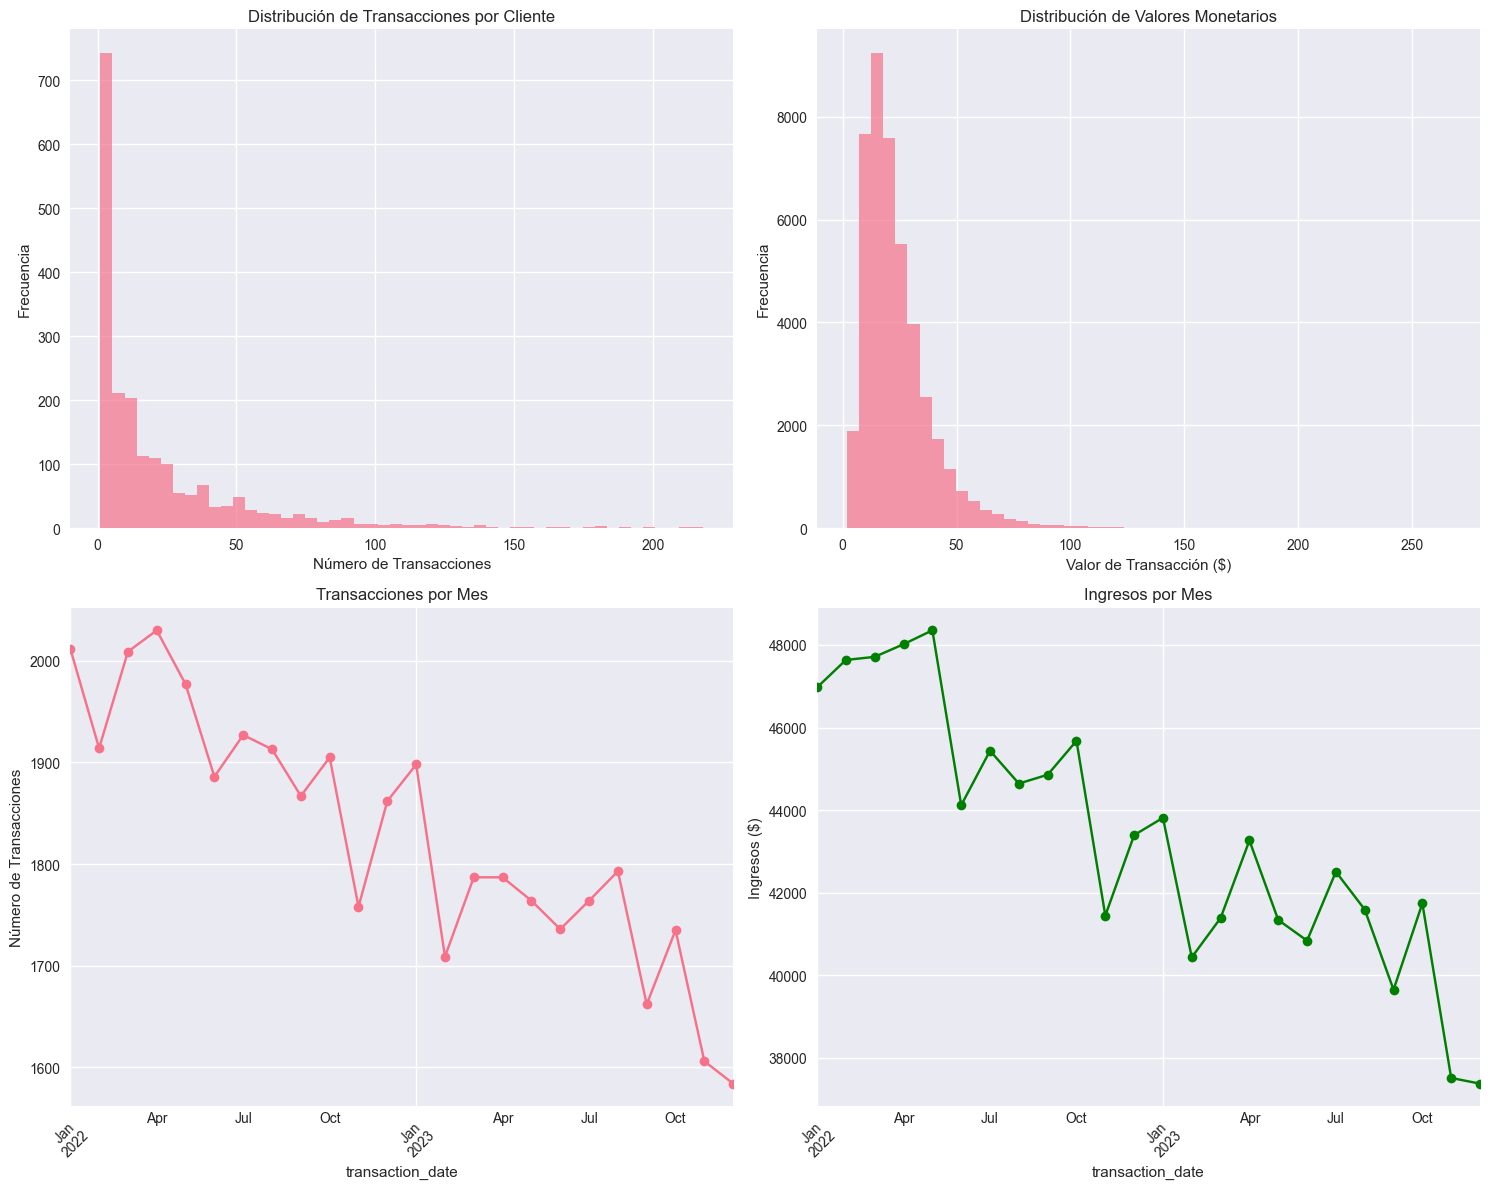

In [7]:
# Visualizaciones exploratorias
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de transacciones por cliente
transactions_per_customer.plot(kind='hist', bins=50, alpha=0.7, ax=axes[0,0])
axes[0,0].set_title('Distribución de Transacciones por Cliente')
axes[0,0].set_xlabel('Número de Transacciones')
axes[0,0].set_ylabel('Frecuencia')

# 2. Distribución de valores monetarios
df_transactions['monetary_value'].plot(kind='hist', bins=50, alpha=0.7, ax=axes[0,1])
axes[0,1].set_title('Distribución de Valores Monetarios')
axes[0,1].set_xlabel('Valor de Transacción ($)')
axes[0,1].set_ylabel('Frecuencia')

# 3. Transacciones por mes
monthly_transactions = df_transactions.set_index('transaction_date').resample('M').size()
monthly_transactions.plot(ax=axes[1,0], marker='o')
axes[1,0].set_title('Transacciones por Mes')
axes[1,0].set_ylabel('Número de Transacciones')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Valor total por mes
monthly_revenue = df_transactions.set_index('transaction_date').resample('M')['monetary_value'].sum()
monthly_revenue.plot(ax=axes[1,1], marker='o', color='green')
axes[1,1].set_title('Ingresos por Mes')
axes[1,1].set_ylabel('Ingresos ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. 🔧 Preparación de Datos para Lifetimes

Los modelos BTYD requieren un formato específico de datos. Vamos a transformar nuestros datos de transacciones:

In [8]:
# Dividir datos en calibración (entrenamiento) y holdout (validación)
# Usaremos los primeros 18 meses para calibración y los últimos 6 para validación

calibration_end = pd.to_datetime('2023-06-30')
observation_end = pd.to_datetime('2023-12-31')

# Filtrar datos de calibración
df_calibration = df_transactions[df_transactions['transaction_date'] <= calibration_end].copy()
df_holdout = df_transactions[
    (df_transactions['transaction_date'] > calibration_end) & 
    (df_transactions['transaction_date'] <= observation_end)
].copy()

print(f"📊 DIVISIÓN DE DATOS:")
print(f"Calibración: {len(df_calibration):,} transacciones (hasta {calibration_end.strftime('%Y-%m-%d')})")
print(f"Holdout: {len(df_holdout):,} transacciones ({calibration_end.strftime('%Y-%m-%d')} - {observation_end.strftime('%Y-%m-%d')})")

# Transformar a formato RFM (Recency, Frequency, Monetary)
summary_cal = summary_data_from_transaction_data(
    df_calibration,
    'customer_id',
    'transaction_date',
    'monetary_value',
    observation_period_end=calibration_end
)

# Para datos completos (calibración + holdout)
summary_full = summary_data_from_transaction_data(
    df_transactions,
    'customer_id', 
    'transaction_date',
    'monetary_value',
    observation_period_end=observation_end
)

print(f"\n🔄 DATOS TRANSFORMADOS:")
print(f"Clientes en calibración: {len(summary_cal):,}")
print(f"Clientes en datos completos: {len(summary_full):,}")

# Mostrar explicación de las columnas
print("\n📖 EXPLICACIÓN DE COLUMNAS:")
print("• frequency: Número de transacciones repetidas (total - 1)")
print("• recency: Días desde la primera hasta la última compra")
print("• T: Días desde la primera compra hasta el fin del período")
print("• monetary_value: Valor promedio por transacción (excluyendo la primera)")

summary_cal.head(10)

📊 DIVISIÓN DE DATOS:
Calibración: 33,686 transacciones (hasta 2023-06-30)
Holdout: 10,199 transacciones (2023-06-30 - 2023-12-31)

🔄 DATOS TRANSFORMADOS:
Clientes en calibración: 2,000
Clientes en datos completos: 2,000

📖 EXPLICACIÓN DE COLUMNAS:
• frequency: Número de transacciones repetidas (total - 1)
• recency: Días desde la primera hasta la última compra
• T: Días desde la primera compra hasta el fin del período
• monetary_value: Valor promedio por transacción (excluyendo la primera)


,frequency,recency,T,monetary_value
customer_id,,,,
C0001,0.0,0.0,544.0,0.000000
C0002,118.0,515.0,523.0,17.252119
C0003,54.0,485.0,486.0,47.854259
C0004,1.0,387.0,468.0,22.390000
C0005,0.0,0.0,522.0,0.000000
C0006,4.0,514.0,540.0,8.592500
C0007,8.0,276.0,486.0,22.141250
C0008,0.0,0.0,479.0,0.000000
C0009,0.0,0.0,521.0,0.000000


📈 ESTADÍSTICAS RFM (Calibración)
       frequency  recency        T  monetary_value
count    2000.00  2000.00  2000.00         2000.00
mean       15.16   344.02   516.36           19.53
std        20.49   199.92    28.72           15.51
min         0.00     0.00   254.00            0.00
25%         1.00   180.00   505.00           10.00
50%         7.00   446.00   524.00           17.86
75%        21.25   503.00   537.00           27.19
max       140.00   544.00   545.00          154.87


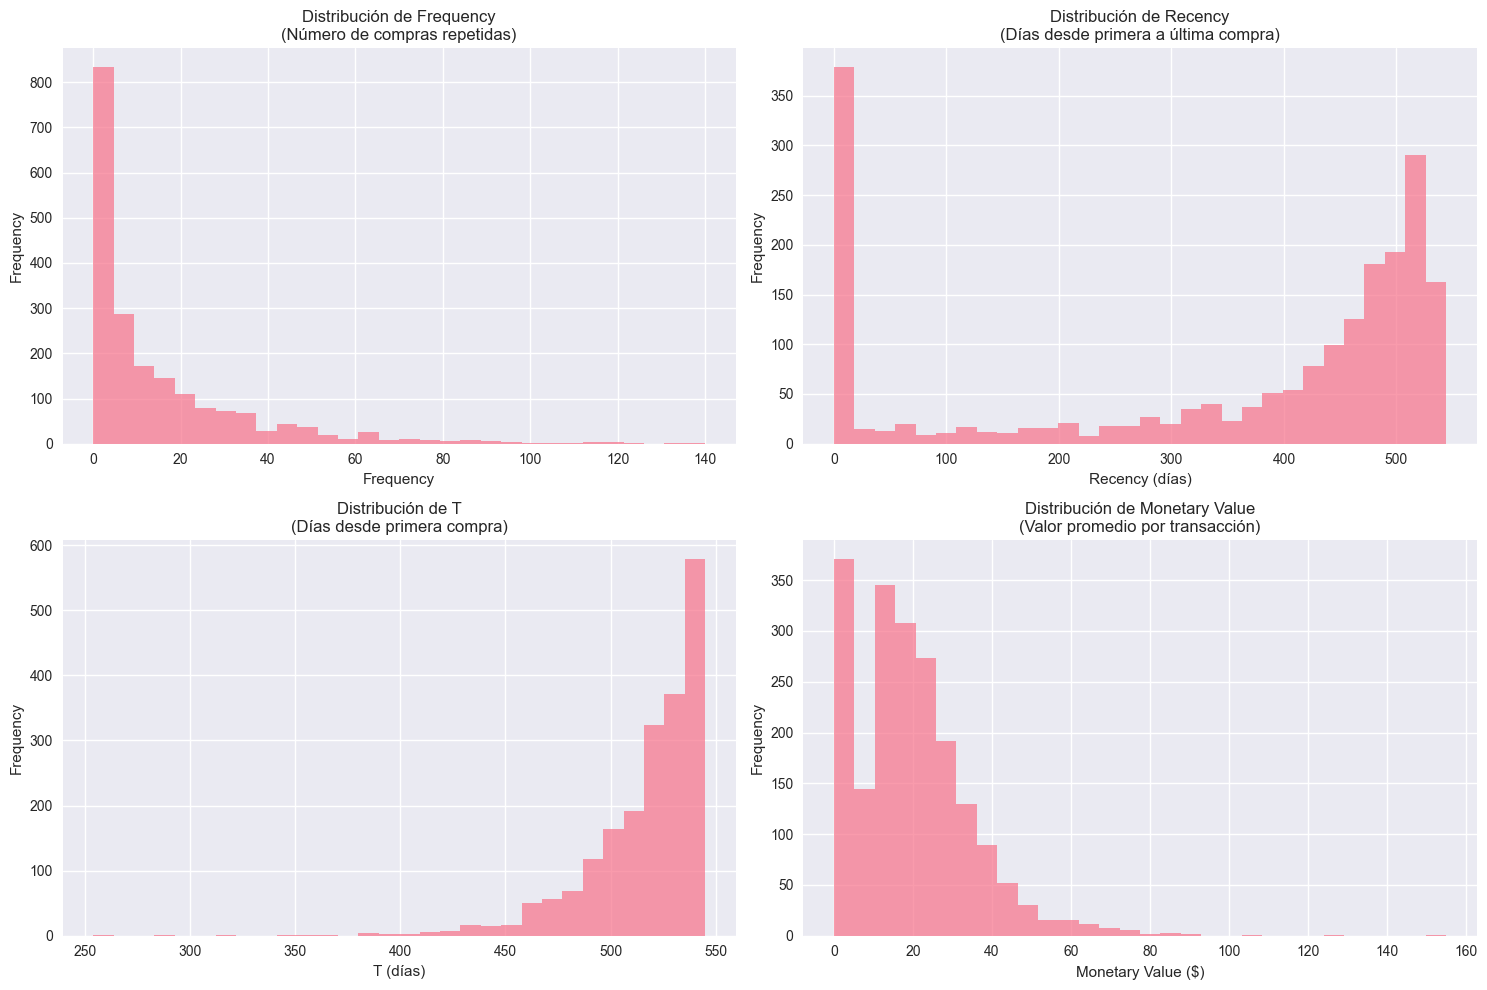

In [9]:
# Estadísticas del dataset RFM
print("📈 ESTADÍSTICAS RFM (Calibración)")
print("="*40)
print(summary_cal.describe().round(2))

# Visualizar distribuciones RFM
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Frequency
summary_cal['frequency'].plot(kind='hist', bins=30, alpha=0.7, ax=axes[0,0])
axes[0,0].set_title('Distribución de Frequency\n(Número de compras repetidas)')
axes[0,0].set_xlabel('Frequency')

# Recency  
summary_cal['recency'].plot(kind='hist', bins=30, alpha=0.7, ax=axes[0,1])
axes[0,1].set_title('Distribución de Recency\n(Días desde primera a última compra)')
axes[0,1].set_xlabel('Recency (días)')

# T
summary_cal['T'].plot(kind='hist', bins=30, alpha=0.7, ax=axes[1,0])
axes[1,0].set_title('Distribución de T\n(Días desde primera compra)')
axes[1,0].set_xlabel('T (días)')

# Monetary Value
summary_cal['monetary_value'].plot(kind='hist', bins=30, alpha=0.7, ax=axes[1,1])
axes[1,1].set_title('Distribución de Monetary Value\n(Valor promedio por transacción)')
axes[1,1].set_xlabel('Monetary Value ($)')

plt.tight_layout()
plt.show()

## 5. 🎯 Modelo BG/NBD (Beta-Geometric/Negative Binomial Distribution)

Este modelo predice:
- **¿Qué clientes están "vivos" vs "muertos"?**
- **¿Cuántas compras futuras realizará cada cliente?**

### Supuestos del modelo:
1. **Mientras está "vivo"**, el cliente realiza compras según un proceso Poisson
2. **Cada cliente** tiene una probabilidad de "morir" (dejar de comprar) después de cada transacción
3. **La heterogeneidad** entre clientes se modela con distribuciones Beta y Gamma

In [11]:
# Ajustar el modelo BG/NBD
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Pequeña penalización para regularización

# Entrenar con datos de calibración
bgf.fit(
    summary_cal['frequency'], 
    summary_cal['recency'], 
    summary_cal['T']
)

print("🎯 MODELO BG/NBD AJUSTADO")
print("="*35)
print(bgf.summary)

# Interpretación de parámetros
print("\n📊 INTERPRETACIÓN DE PARÁMETROS:")
print(f"• r: {bgf.params_['r']:.3f} - Forma de la distribución Gamma (frecuencia de compra)")
print(f"• alpha: {bgf.params_['alpha']:.3f} - Escala de la distribución Gamma (frecuencia de compra)")
print(f"• a: {bgf.params_['a']:.3f} - Forma de la distribución Beta (probabilidad de dropout)")
print(f"• b: {bgf.params_['b']:.3f} - Forma de la distribución Beta (probabilidad de dropout)")

# Estadísticas de ajuste
print(f"\n📈 ESTADÍSTICAS DE AJUSTE:")
# print(f"• Log-likelihood: {bgf.log_likelihood_:.2f}")
# print(f"• AIC: {bgf.AIC_:.2f}")
# print(f"• BIC: {bgf.BIC_:.2f}")

🎯 MODELO BG/NBD AJUSTADO
            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.504287  0.016344         0.472253         0.536322
alpha  15.905290  0.729624        14.475227        17.335353
a       0.021197  0.002964         0.015388         0.027006
b       0.655760  0.096580         0.466463         0.845058

📊 INTERPRETACIÓN DE PARÁMETROS:
• r: 0.504 - Forma de la distribución Gamma (frecuencia de compra)
• alpha: 15.905 - Escala de la distribución Gamma (frecuencia de compra)
• a: 0.021 - Forma de la distribución Beta (probabilidad de dropout)
• b: 0.656 - Forma de la distribución Beta (probabilidad de dropout)

📈 ESTADÍSTICAS DE AJUSTE:


## 6. 🔮 Predicciones con el Modelo BG/NBD

In [12]:
# Calcular predicciones para cada cliente
summary_cal['predicted_purchases_1_month'] = bgf.predict(
    30,  # 30 días = 1 mes
    summary_cal['frequency'], 
    summary_cal['recency'], 
    summary_cal['T']
)

summary_cal['predicted_purchases_3_months'] = bgf.predict(
    90,  # 90 días = 3 meses
    summary_cal['frequency'], 
    summary_cal['recency'], 
    summary_cal['T']
)

summary_cal['prob_alive'] = bgf.conditional_probability_alive(
    summary_cal['frequency'], 
    summary_cal['recency'], 
    summary_cal['T']
)

# Mostrar ejemplos de predicciones
print("🔮 EJEMPLOS DE PREDICCIONES:")
print("="*60)

# Seleccionar algunos clientes con diferentes perfiles
examples = summary_cal.nlargest(5, 'frequency')[['frequency', 'recency', 'T', 'prob_alive', 
                                                  'predicted_purchases_1_month', 
                                                  'predicted_purchases_3_months']]
print("Top 5 clientes más frecuentes:")
print(examples.round(3))

print("\n" + "="*60)
examples_new = summary_cal[summary_cal['frequency'] == 0].head()[['frequency', 'recency', 'T', 'prob_alive', 
                                                                   'predicted_purchases_1_month', 
                                                                   'predicted_purchases_3_months']]
print("Clientes con una sola compra:")
print(examples_new.round(3))

🔮 EJEMPLOS DE PREDICCIONES:
Top 5 clientes más frecuentes:
             frequency  recency      T  prob_alive  \
customer_id                                          
C0912            140.0    532.0  533.0       1.000   
C0442            137.0    479.0  480.0       1.000   
C1146            132.0    537.0  544.0       0.999   
C1004            126.0    509.0  515.0       0.999   
C1278            121.0    540.0  541.0       1.000   

             predicted_purchases_1_month  predicted_purchases_3_months  
customer_id                                                             
C0912                              7.673                        22.995  
C0442                              8.311                        24.905  
C1146                              7.090                        21.246  
C1004                              7.139                        21.393  
C1278                              6.540                        19.600  

Clientes con una sola compra:
             frequen

👥 SEGMENTACIÓN DE CLIENTES:
           Count  Avg_Frequency  Avg_Prob_Alive  Avg_Pred_3m  Avg_Monetary
segment                                                                   
At Risk       57          4.860           0.516        0.458        20.973
Champions    762         33.594           0.994        5.733        24.475
Lost          67         13.433           0.084        0.066        24.655
Loyal       1114          3.189           0.972        0.609        15.766


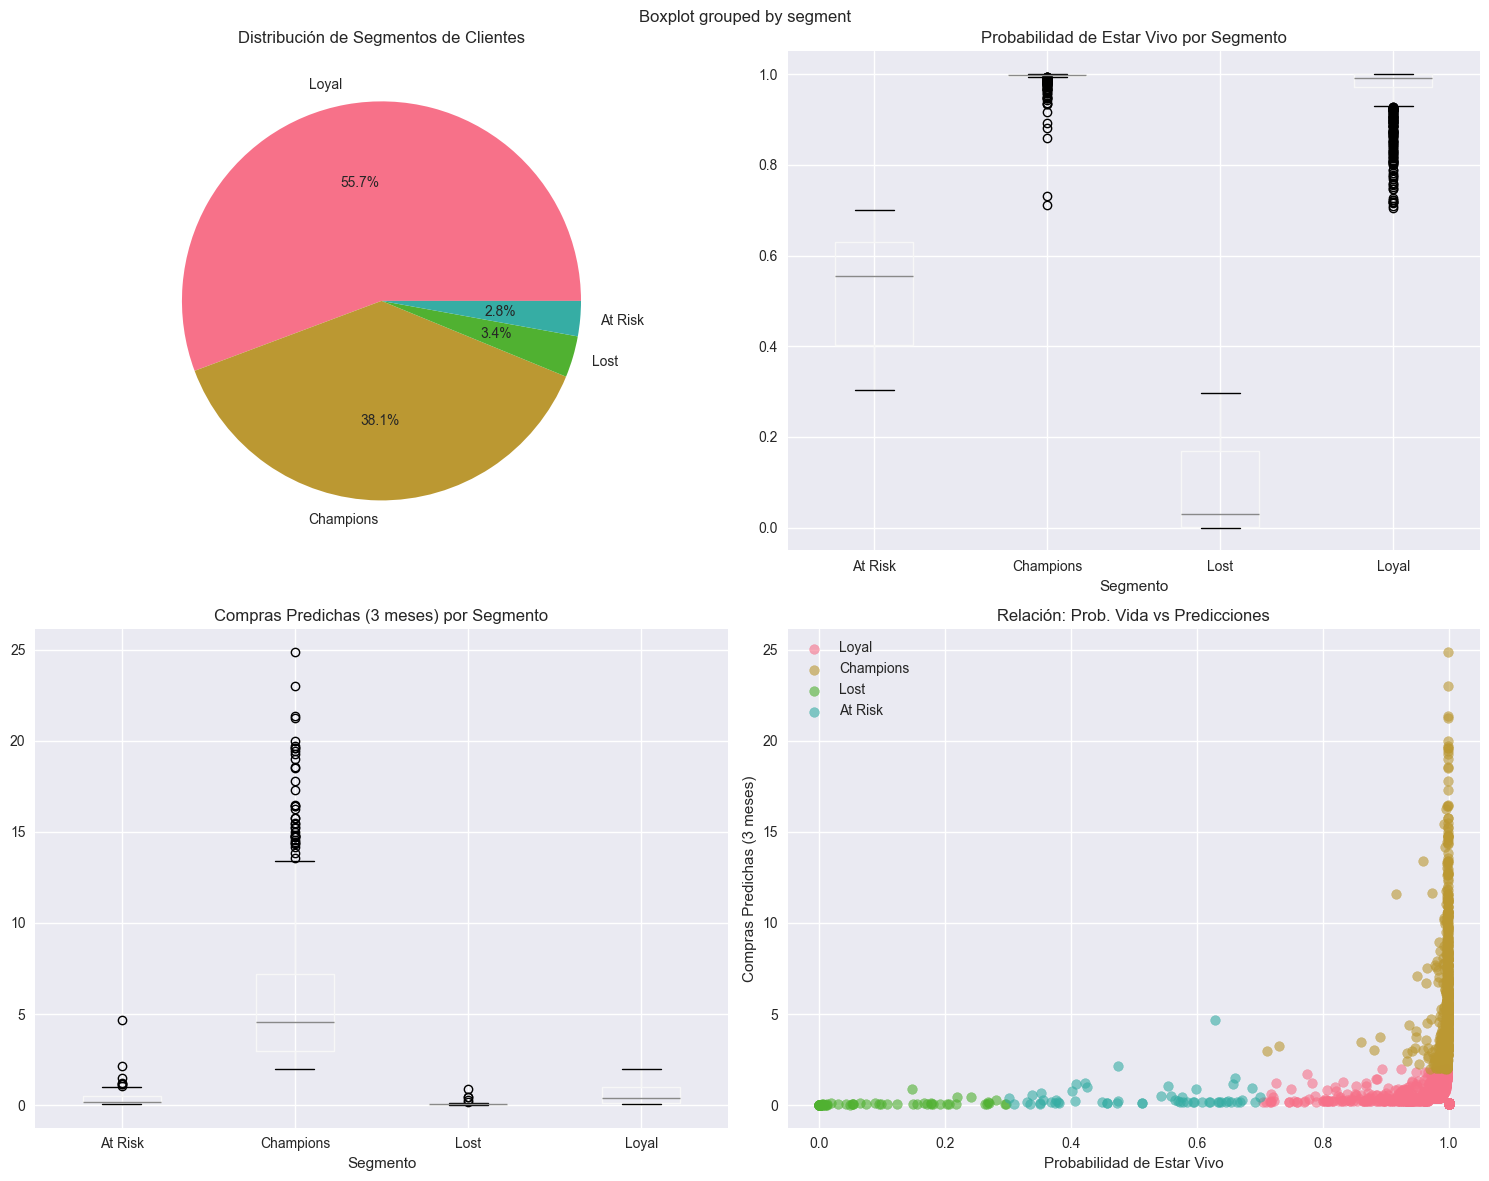

In [13]:
# Análisis de segmentación basado en predicciones
def segment_customers(df):
    """
    Segmenta clientes basado en probabilidad de estar vivo y frecuencia
    """
    conditions = [
        (df['prob_alive'] >= 0.7) & (df['predicted_purchases_3_months'] >= 2),
        (df['prob_alive'] >= 0.7) & (df['predicted_purchases_3_months'] < 2),
        (df['prob_alive'] >= 0.3) & (df['prob_alive'] < 0.7),
        (df['prob_alive'] < 0.3)
    ]
    
    choices = ['Champions', 'Loyal', 'At Risk', 'Lost']
    
    return np.select(conditions, choices, default='Unknown')

summary_cal['segment'] = segment_customers(summary_cal)

# Estadísticas por segmento
segment_stats = summary_cal.groupby('segment').agg({
    'frequency': ['count', 'mean'],
    'prob_alive': 'mean',
    'predicted_purchases_3_months': 'mean',
    'monetary_value': 'mean'
}).round(3)

segment_stats.columns = ['Count', 'Avg_Frequency', 'Avg_Prob_Alive', 'Avg_Pred_3m', 'Avg_Monetary']
print("👥 SEGMENTACIÓN DE CLIENTES:")
print("="*50)
print(segment_stats)

# Visualizar segmentación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de segmentos
segment_counts = summary_cal['segment'].value_counts()
segment_counts.plot(kind='pie', autopct='%1.1f%%', ax=axes[0,0])
axes[0,0].set_title('Distribución de Segmentos de Clientes')
axes[0,0].set_ylabel('')

# Probabilidad de estar vivo por segmento
summary_cal.boxplot(column='prob_alive', by='segment', ax=axes[0,1])
axes[0,1].set_title('Probabilidad de Estar Vivo por Segmento')
axes[0,1].set_xlabel('Segmento')

# Predicciones por segmento
summary_cal.boxplot(column='predicted_purchases_3_months', by='segment', ax=axes[1,0])
axes[1,0].set_title('Compras Predichas (3 meses) por Segmento')
axes[1,0].set_xlabel('Segmento')

# Scatter: Probabilidad vs Predicciones
for segment in summary_cal['segment'].unique():
    data = summary_cal[summary_cal['segment'] == segment]
    axes[1,1].scatter(data['prob_alive'], data['predicted_purchases_3_months'], 
                     label=segment, alpha=0.6)
axes[1,1].set_xlabel('Probabilidad de Estar Vivo')
axes[1,1].set_ylabel('Compras Predichas (3 meses)')
axes[1,1].set_title('Relación: Prob. Vida vs Predicciones')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 7. 📊 Visualizaciones Avanzadas del Modelo BG/NBD

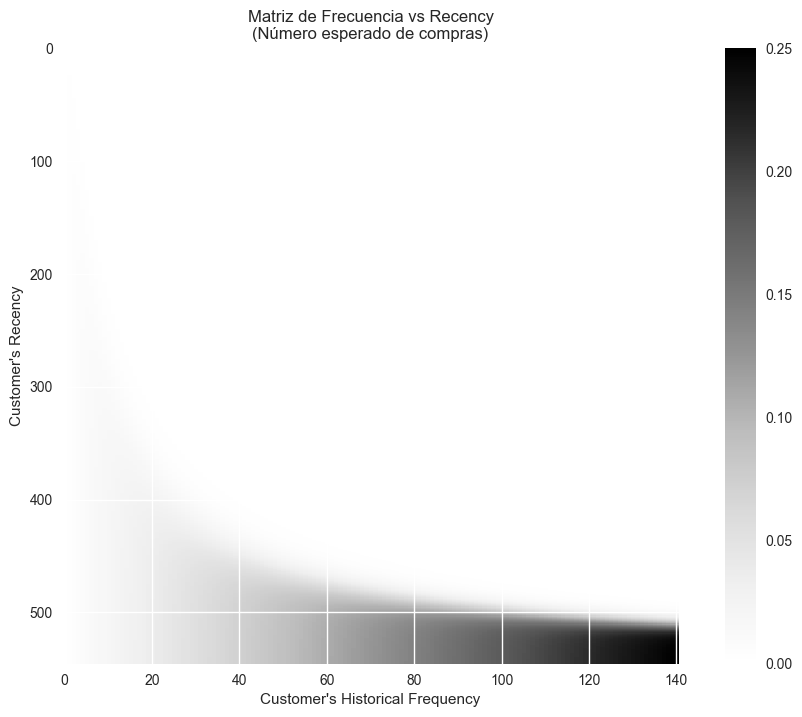

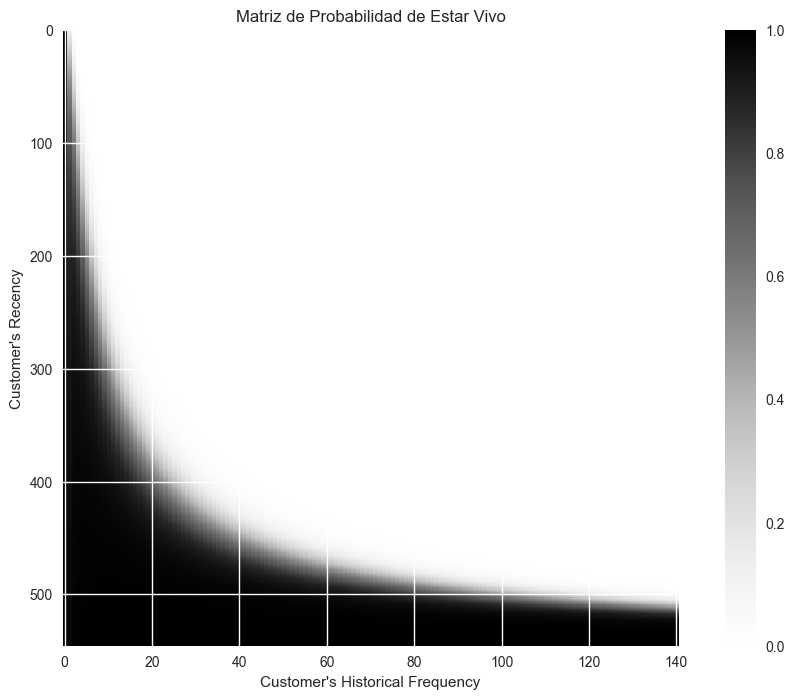

In [14]:
# 1. Matriz de Frecuencia-Recency
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf)
plt.title('Matriz de Frecuencia vs Recency\n(Número esperado de compras)')
plt.show()

# 2. Matriz de Probabilidad de estar vivo
plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf)
plt.title('Matriz de Probabilidad de Estar Vivo')
plt.show()

## 8. ✅ Validación del Modelo

Vamos a validar qué tan bien predice nuestro modelo comparando con datos reales del período holdout:

In [17]:
# Preparar datos de validación
# Obtener compras reales en el período holdout
holdout_summary = summary_data_from_transaction_data(
    df_holdout,
    'customer_id',
    'transaction_date', 
    'monetary_value',
    observation_period_end=observation_end
)

# Unir con datos de calibración para tener las predicciones
validation_data = summary_cal.join(
    holdout_summary[['frequency']].rename(columns={'frequency': 'actual_purchases_holdout'}),
    how='left'
).fillna(0)

# Calcular predicciones para el período holdout (6 meses = 183 días)
holdout_days = (observation_end - calibration_end).days
validation_data['predicted_purchases_holdout'] = bgf.predict(
    holdout_days,
    validation_data['frequency'],
    validation_data['recency'], 
    validation_data['T']
)

# Métricas de validación
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

mae = mean_absolute_error(validation_data['actual_purchases_holdout'], 
                         validation_data['predicted_purchases_holdout'])
rmse = np.sqrt(mean_squared_error(validation_data['actual_purchases_holdout'], 
                                 validation_data['predicted_purchases_holdout']))
correlation = stats.pearsonr(validation_data['actual_purchases_holdout'], 
                           validation_data['predicted_purchases_holdout'])[0]

print("✅ MÉTRICAS DE VALIDACIÓN:")
print("="*35)
print(f"• MAE (Error Absoluto Medio): {mae:.3f}")
print(f"• RMSE (Raíz del Error Cuadrático Medio): {rmse:.3f}")
print(f"• Correlación: {correlation:.3f}")

# Estadísticas descriptivas
print(f"\n📊 COMPARACIÓN AGREGADA:")
print(f"• Total compras reales (holdout): {validation_data['actual_purchases_holdout'].sum():.0f}")
print(f"• Total compras predichas (holdout): {validation_data['predicted_purchases_holdout'].sum():.0f}")
print(f"• Error relativo: {((validation_data['predicted_purchases_holdout'].sum() - validation_data['actual_purchases_holdout'].sum()) / validation_data['actual_purchases_holdout'].sum() * 100):.1f}%")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Visualizaciones de validación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: Predicho vs Real
axes[0,0].scatter(validation_data['predicted_purchases_holdout'], 
                 validation_data['actual_purchases_holdout'], alpha=0.6)
max_val = max(validation_data['predicted_purchases_holdout'].max(), 
             validation_data['actual_purchases_holdout'].max())
axes[0,0].plot([0, max_val], [0, max_val], 'r--', label='Línea perfecta')
axes[0,0].set_xlabel('Compras Predichas')
axes[0,0].set_ylabel('Compras Reales')
axes[0,0].set_title('Predicho vs Real (Período Holdout)')
axes[0,0].legend()

# 2. Residuos
residuals = validation_data['actual_purchases_holdout'] - validation_data['predicted_purchases_holdout']
axes[0,1].scatter(validation_data['predicted_purchases_holdout'], residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Compras Predichas')
axes[0,1].set_ylabel('Residuos (Real - Predicho)')
axes[0,1].set_title('Gráfico de Residuos')

# 3. Distribución de errores
residuals.hist(bins=30, alpha=0.7, ax=axes[1,0])
axes[1,0].set_title('Distribución de Errores')
axes[1,0].set_xlabel('Error (Real - Predicho)')
axes[1,0].set_ylabel('Frecuencia')

# 4. Calibración por deciles
validation_data['predicted_decile'] = pd.qcut(validation_data['predicted_purchases_holdout'], 
                                            10, labels=False, duplicates='drop')
decile_comparison = validation_data.groupby('predicted_decile').agg({
    'predicted_purchases_holdout': 'mean',
    'actual_purchases_holdout': 'mean'
})

decile_comparison.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Calibración por Deciles de Predicción')
axes[1,1].set_xlabel('Decil de Predicción')
axes[1,1].set_ylabel('Promedio de Compras')
axes[1,1].legend(['Predicho', 'Real'])
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 9. 💰 Modelo Gamma-Gamma para Valor Monetario

El modelo Gamma-Gamma predice el valor promedio de las transacciones futuras de cada cliente.

### Supuestos:
1. El valor de las transacciones varía aleatoriamente alrededor del valor promedio del cliente
2. Los valores promedio de diferentes clientes siguen una distribución Gamma
3. El valor monetario es independiente de la frecuencia de compra

In [ ]:
# Filtrar clientes con al menos 2 transacciones (necesario para Gamma-Gamma)
summary_monetary = summary_cal[summary_cal['frequency'] > 0].copy()

print(f"🔄 DATOS PARA MODELO GAMMA-GAMMA:")
print(f"Clientes con ≥2 transacciones: {len(summary_monetary):,} de {len(summary_cal):,} ({len(summary_monetary)/len(summary_cal)*100:.1f}%)")

# Ajustar modelo Gamma-Gamma
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(
    summary_monetary['frequency'],
    summary_monetary['monetary_value']
)

print("\n💰 MODELO GAMMA-GAMMA AJUSTADO:")
print("="*40)
print(ggf.summary)

# Interpretación de parámetros
print("\n📊 INTERPRETACIÓN DE PARÁMETROS:")
print(f"• p: {ggf.params_['p']:.3f} - Forma de la distribución Gamma (valor por transacción)")
print(f"• q: {ggf.params_['q']:.3f} - Forma de la distribución Gamma (valor promedio por cliente)")
print(f"• v: {ggf.params_['v']:.3f} - Escala de la distribución Gamma (valor promedio por cliente)")

print(f"\n📈 ESTADÍSTICAS DE AJUSTE:")
print(f"• Log-likelihood: {ggf.log_likelihood_:.2f}")
print(f"• AIC: {ggf.AIC_:.2f}")
print(f"• BIC: {ggf.BIC_:.2f}")

In [ ]:
# Predicciones de valor monetario
summary_monetary['predicted_avg_value'] = ggf.conditional_expected_average_profit(
    summary_monetary['frequency'],
    summary_monetary['monetary_value']
)

# Análisis de predicciones monetarias
print("💰 ANÁLISIS DE PREDICCIONES MONETARIAS:")
print("="*50)
print(f"Valor promedio real: ${summary_monetary['monetary_value'].mean():.2f}")
print(f"Valor promedio predicho: ${summary_monetary['predicted_avg_value'].mean():.2f}")
print(f"Correlación real vs predicho: {stats.pearsonr(summary_monetary['monetary_value'], summary_monetary['predicted_avg_value'])[0]:.3f}")

# Ejemplos de clientes
examples_monetary = summary_monetary.nlargest(10, 'monetary_value')[[
    'frequency', 'monetary_value', 'predicted_avg_value'
]].round(2)
examples_monetary['difference'] = examples_monetary['predicted_avg_value'] - examples_monetary['monetary_value']

print("\n🔍 TOP 10 CLIENTES POR VALOR MONETARIO:")
print(examples_monetary)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter: Valor real vs predicho
axes[0].scatter(summary_monetary['monetary_value'], 
               summary_monetary['predicted_avg_value'], alpha=0.6)
max_val = max(summary_monetary['monetary_value'].max(), 
             summary_monetary['predicted_avg_value'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Línea perfecta')
axes[0].set_xlabel('Valor Monetario Real')
axes[0].set_ylabel('Valor Monetario Predicho')
axes[0].set_title('Valor Real vs Predicho')
axes[0].legend()

# Distribución de diferencias
diff = summary_monetary['predicted_avg_value'] - summary_monetary['monetary_value']
diff.hist(bins=30, alpha=0.7, ax=axes[1])
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Diferencia (Predicho - Real)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Diferencias')

plt.tight_layout()
plt.show()

## 10. 🌟 Customer Lifetime Value (CLV)

Combinamos ambos modelos para calcular el valor de vida del cliente:

In [ ]:
# Calcular CLV para diferentes períodos
time_periods = [30, 90, 180, 365]  # 1 mes, 3 meses, 6 meses, 1 año
period_names = ['1_mes', '3_meses', '6_meses', '1_año']

# Calcular CLV solo para clientes con datos monetarios
clv_data = summary_monetary.copy()

for period, name in zip(time_periods, period_names):
    clv_data[f'clv_{name}'] = ggf.customer_lifetime_value(
        bgf,
        clv_data['frequency'],
        clv_data['recency'],
        clv_data['T'],
        clv_data['monetary_value'],
        time=period,
        freq='D'  # frecuencia diaria
    )

print("🌟 CUSTOMER LIFETIME VALUE (CLV):")
print("="*45)

# Estadísticas de CLV
clv_stats = clv_data[[f'clv_{name}' for name in period_names]].describe()
print("Estadísticas de CLV por período:")
print(clv_stats.round(2))

# Top clientes por CLV
print("\n🏆 TOP 10 CLIENTES POR CLV (1 año):")
top_clv = clv_data.nlargest(10, 'clv_1_año')[[
    'frequency', 'monetary_value', 'prob_alive',
    'clv_1_mes', 'clv_3_meses', 'clv_6_meses', 'clv_1_año'
]].round(2)
print(top_clv)

# Análisis por segmento
clv_by_segment = clv_data.groupby('segment')[[
    f'clv_{name}' for name in period_names
]].mean().round(2)

print("\n👥 CLV PROMEDIO POR SEGMENTO:")
print(clv_by_segment)

In [ ]:
# Visualizaciones de CLV
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de CLV (1 año)
clv_data['clv_1_año'].hist(bins=50, alpha=0.7, ax=axes[0,0])
axes[0,0].set_title('Distribución de CLV (1 año)')
axes[0,0].set_xlabel('CLV ($)')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].axvline(clv_data['clv_1_año'].mean(), color='red', linestyle='--', 
                 label=f'Promedio: ${clv_data["clv_1_año"].mean():.0f}')
axes[0,0].legend()

# 2. CLV vs Probabilidad de estar vivo
axes[0,1].scatter(clv_data['prob_alive'], clv_data['clv_1_año'], alpha=0.6)
axes[0,1].set_xlabel('Probabilidad de Estar Vivo')
axes[0,1].set_ylabel('CLV 1 año ($)')
axes[0,1].set_title('CLV vs Probabilidad de Vida')

# 3. CLV vs Frecuencia
axes[1,0].scatter(clv_data['frequency'], clv_data['clv_1_año'], alpha=0.6)
axes[1,0].set_xlabel('Frecuencia de Compras')
axes[1,0].set_ylabel('CLV 1 año ($)')
axes[1,0].set_title('CLV vs Frecuencia de Compras')

# 4. CLV por segmento
clv_by_segment.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('CLV Promedio por Segmento y Período')
axes[1,1].set_xlabel('Segmento')
axes[1,1].set_ylabel('CLV ($)')
axes[1,1].legend(title='Período')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Gráfico de evolución de CLV por período
plt.figure(figsize=(12, 6))
periods_days = time_periods
avg_clv_by_period = [clv_data[f'clv_{name}'].mean() for name in period_names]

plt.plot(periods_days, avg_clv_by_period, marker='o', linewidth=2, markersize=8)
plt.title('Evolución del CLV Promedio por Período')
plt.xlabel('Días')
plt.ylabel('CLV Promedio ($)')
plt.grid(True, alpha=0.3)

# Añadir etiquetas
for i, (days, clv, name) in enumerate(zip(periods_days, avg_clv_by_period, period_names)):
    plt.annotate(f'${clv:.0f}\n({name.replace("_", " ")})', 
                (days, clv), textcoords="offset points", 
                xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## 11. 📋 Reporte Ejecutivo y Recomendaciones

In [ ]:
# Generar reporte ejecutivo
total_customers = len(summary_cal)
total_clv_1_year = clv_data['clv_1_año'].sum()
avg_clv_1_year = clv_data['clv_1_año'].mean()
median_clv_1_year = clv_data['clv_1_año'].median()

# Calcular métricas por segmento
segment_summary = summary_cal.groupby('segment').agg({
    'frequency': 'count',
    'prob_alive': 'mean',
    'predicted_purchases_3_months': 'mean'
}).round(3)
segment_summary.columns = ['Customers', 'Avg_Prob_Alive', 'Avg_Pred_3m']

# Añadir CLV al resumen
clv_segment_summary = clv_data.groupby('segment')['clv_1_año'].agg(['mean', 'sum']).round(2)
clv_segment_summary.columns = ['Avg_CLV_1y', 'Total_CLV_1y']

final_summary = segment_summary.join(clv_segment_summary, how='left').fillna(0)

print("📊 REPORTE EJECUTIVO - ANÁLISIS DE CLIENTES")
print("="*60)

print(f"\n🎯 MÉTRICAS GENERALES:")
print(f"• Total de clientes analizados: {total_customers:,}")
print(f"• CLV total proyectado (1 año): ${total_clv_1_year:,.0f}")
print(f"• CLV promedio por cliente: ${avg_clv_1_year:.0f}")
print(f"• CLV mediano por cliente: ${median_clv_1_year:.0f}")

print(f"\n👥 RESUMEN POR SEGMENTO:")
print(final_summary)

print(f"\n🔍 INSIGHTS PRINCIPALES:")
champions_pct = (final_summary.loc['Champions', 'Customers'] / total_customers * 100)
lost_pct = (final_summary.loc['Lost', 'Customers'] / total_customers * 100)
champions_clv_contribution = (final_summary.loc['Champions', 'Total_CLV_1y'] / total_clv_1_year * 100)

print(f"• {champions_pct:.1f}% de clientes son 'Champions', contribuyendo {champions_clv_contribution:.1f}% del CLV total")
print(f"• {lost_pct:.1f}% de clientes están clasificados como 'Lost'")
print(f"• El segmento 'Champions' tiene un CLV promedio {final_summary.loc['Champions', 'Avg_CLV_1y'] / avg_clv_1_year:.1f}x mayor que el promedio")

print(f"\n📈 RECOMENDACIONES ESTRATÉGICAS:")
print("\n1. CHAMPIONS (Alta frecuencia, alta probabilidad de vida):")
print("   • Programa de fidelización VIP")
print("   • Ofertas exclusivas y acceso prioritario")
print("   • Programa de referidos con incentivos")

print("\n2. LOYAL (Baja frecuencia, alta probabilidad de vida):")
print("   • Campañas de cross-selling y up-selling")
print("   • Recordatorios personalizados")
print("   • Descuentos por volumen para aumentar frecuencia")

print("\n3. AT RISK (Probabilidad media de vida):")
print("   • Campañas de reactivación urgente")
print("   • Encuestas de satisfacción")
print("   • Ofertas especiales de retención")

print("\n4. LOST (Baja probabilidad de vida):")
print("   • Campañas de reconquista con descuentos agresivos")
print("   • Inversión mínima en marketing")
print("   • Análisis de causas de abandono")

print(f"\n💡 PRÓXIMOS PASOS:")
print("• Implementar scoring automático de clientes")
print("• Configurar alertas para clientes 'At Risk'")
print("• Personalizar campañas por segmento")
print("• Re-entrenar modelos mensualmente")
print("• A/B testing de estrategias de retención")

## 12. 💾 Exportar Resultados

Guardemos los resultados para uso futuro:

In [ ]:
# Crear dataset final con todas las predicciones
final_dataset = summary_cal.copy()

# Añadir CLV para todos los clientes (0 para clientes con una sola compra)
final_dataset = final_dataset.join(
    clv_data[['clv_1_mes', 'clv_3_meses', 'clv_6_meses', 'clv_1_año', 'predicted_avg_value']],
    how='left'
).fillna(0)

# Añadir información adicional
final_dataset['model_version'] = '1.0'
final_dataset['prediction_date'] = pd.Timestamp.now()
final_dataset['calibration_end'] = calibration_end

# Guardar en diferentes formatos
final_dataset.to_csv('/home/claude/customer_predictions.csv', index=True)
final_dataset.to_excel('/home/claude/customer_predictions.xlsx', index=True)

# Guardar modelos (usando pickle)
import pickle

with open('/home/claude/bgf_model.pkl', 'wb') as f:
    pickle.dump(bgf, f)

with open('/home/claude/ggf_model.pkl', 'wb') as f:
    pickle.dump(ggf, f)

# Guardar parámetros del modelo
model_params = {
    'bgf_params': bgf.params_,
    'ggf_params': ggf.params_,
    'bgf_log_likelihood': bgf.log_likelihood_,
    'ggf_log_likelihood': ggf.log_likelihood_,
    'calibration_period': str(calibration_end),
    'observation_period': str(observation_end),
    'total_customers': len(final_dataset),
    'customers_with_monetary': len(clv_data)
}

import json
with open('/home/claude/model_parameters.json', 'w') as f:
    json.dump(model_params, f, indent=2, default=str)

print("💾 ARCHIVOS GUARDADOS:")
print("• customer_predictions.csv - Predicciones completas")
print("• customer_predictions.xlsx - Predicciones en Excel")
print("• bgf_model.pkl - Modelo BG/NBD entrenado")
print("• ggf_model.pkl - Modelo Gamma-Gamma entrenado")
print("• model_parameters.json - Parámetros y métricas")

print(f"\n📊 RESUMEN FINAL:")
print(f"Dataset final: {len(final_dataset)} clientes con {final_dataset.shape[1]} características")
print(f"Columnas incluidas: {list(final_dataset.columns)}")

## 13. 🚀 Código de Producción

Función para aplicar los modelos a nuevos datos:

In [ ]:
def score_new_customers(transaction_data, bgf_model, ggf_model, observation_end_date):
    """
    Aplica los modelos entrenados a nuevos datos de transacciones
    
    Parameters:
    -----------
    transaction_data : pd.DataFrame
        DataFrame con columnas: customer_id, transaction_date, monetary_value
    bgf_model : BetaGeoFitter
        Modelo BG/NBD entrenado
    ggf_model : GammaGammaFitter
        Modelo Gamma-Gamma entrenado
    observation_end_date : str or datetime
        Fecha final del período de observación
        
    Returns:
    --------
    pd.DataFrame
        DataFrame con predicciones para cada cliente
    """
    
    # Convertir a formato RFM
    summary = summary_data_from_transaction_data(
        transaction_data,
        'customer_id',
        'transaction_date', 
        'monetary_value',
        observation_period_end=observation_end_date
    )
    
    # Predicciones BG/NBD
    summary['prob_alive'] = bgf_model.conditional_probability_alive(
        summary['frequency'], summary['recency'], summary['T']
    )
    
    summary['predicted_purchases_1m'] = bgf_model.predict(
        30, summary['frequency'], summary['recency'], summary['T']
    )
    
    summary['predicted_purchases_3m'] = bgf_model.predict(
        90, summary['frequency'], summary['recency'], summary['T']
    )
    
    # Segmentación
    summary['segment'] = segment_customers(summary)
    
    # Predicciones Gamma-Gamma (solo para clientes con frequency > 0)
    summary['predicted_avg_value'] = 0
    summary['clv_1_year'] = 0
    
    mask = summary['frequency'] > 0
    if mask.sum() > 0:
        summary.loc[mask, 'predicted_avg_value'] = ggf_model.conditional_expected_average_profit(
            summary.loc[mask, 'frequency'],
            summary.loc[mask, 'monetary_value']
        )
        
        summary.loc[mask, 'clv_1_year'] = ggf_model.customer_lifetime_value(
            bgf_model,
            summary.loc[mask, 'frequency'],
            summary.loc[mask, 'recency'],
            summary.loc[mask, 'T'],
            summary.loc[mask, 'monetary_value'],
            time=365,
            freq='D'
        )
    
    summary['scoring_date'] = pd.Timestamp.now()
    
    return summary

# Ejemplo de uso de la función
print("🚀 FUNCIÓN DE SCORING LISTA PARA PRODUCCIÓN")
print("\nEjemplo de uso:")
print("""
# Cargar modelos
with open('bgf_model.pkl', 'rb') as f:
    bgf = pickle.load(f)
with open('ggf_model.pkl', 'rb') as f:
    ggf = pickle.load(f)

# Aplicar a nuevos datos
new_scores = score_new_customers(new_transaction_data, bgf, ggf, '2024-01-31')
""")

# Guardar la función
with open('/home/claude/scoring_function.py', 'w') as f:
    f.write('''
import pandas as pd
import numpy as np
from lifetimes.utils import summary_data_from_transaction_data

def segment_customers(df):
    """Segmenta clientes basado en probabilidad de estar vivo y frecuencia"""
    conditions = [
        (df['prob_alive'] >= 0.7) & (df['predicted_purchases_3m'] >= 2),
        (df['prob_alive'] >= 0.7) & (df['predicted_purchases_3m'] < 2),
        (df['prob_alive'] >= 0.3) & (df['prob_alive'] < 0.7),
        (df['prob_alive'] < 0.3)
    ]
    choices = ['Champions', 'Loyal', 'At Risk', 'Lost']
    return np.select(conditions, choices, default='Unknown')

''' + '''
def score_new_customers(transaction_data, bgf_model, ggf_model, observation_end_date):
    """Aplica los modelos entrenados a nuevos datos de transacciones"""
    
    summary = summary_data_from_transaction_data(
        transaction_data, 'customer_id', 'transaction_date', 'monetary_value',
        observation_period_end=observation_end_date
    )
    
    summary['prob_alive'] = bgf_model.conditional_probability_alive(
        summary['frequency'], summary['recency'], summary['T']
    )
    
    summary['predicted_purchases_1m'] = bgf_model.predict(
        30, summary['frequency'], summary['recency'], summary['T']
    )
    
    summary['predicted_purchases_3m'] = bgf_model.predict(
        90, summary['frequency'], summary['recency'], summary['T']
    )
    
    summary['segment'] = segment_customers(summary)
    
    summary['predicted_avg_value'] = 0
    summary['clv_1_year'] = 0
    
    mask = summary['frequency'] > 0
    if mask.sum() > 0:
        summary.loc[mask, 'predicted_avg_value'] = ggf_model.conditional_expected_average_profit(
            summary.loc[mask, 'frequency'], summary.loc[mask, 'monetary_value']
        )
        
        summary.loc[mask, 'clv_1_year'] = ggf_model.customer_lifetime_value(
            bgf_model, summary.loc[mask, 'frequency'], summary.loc[mask, 'recency'],
            summary.loc[mask, 'T'], summary.loc[mask, 'monetary_value'],
            time=365, freq='D'
        )
    
    summary['scoring_date'] = pd.Timestamp.now()
    return summary
''')

print("\n✅ Función guardada en 'scoring_function.py'")

## 🎓 Conclusiones y Aprendizajes

### ✅ Lo que aprendimos:

1. **Modelos BTYD**: Los modelos "Buy Till You Die" son potentes para analizar comportamiento de clientes
2. **BG/NBD**: Predice frecuencia de compras y probabilidad de "vida" del cliente
3. **Gamma-Gamma**: Modela el valor monetario promedio por cliente
4. **CLV**: Combinando ambos modelos podemos estimar el valor de vida del cliente
5. **Segmentación**: Los modelos permiten segmentar clientes para estrategias dirigidas

### 🚀 Aplicaciones prácticas:

- **Marketing dirigido** por segmento de cliente
- **Presupuestos de adquisición** basados en CLV predicho
- **Campañas de retención** para clientes "At Risk"
- **Optimización de inventario** basada en demanda predicha
- **Pricing dinámico** según valor del cliente

### 📈 Próximos pasos:

1. **Automatización**: Integrar en pipelines de datos
2. **Monitoreo**: Seguimiento continuo de performance
3. **Experimentación**: A/B testing de estrategias
4. **Extensiones**: Modelos más complejos (Pareto/NBD, etc.)
5. **Personalización**: Adaptar a contexto específico del negocio

---

**🎯 ¡Este notebook te ha dado las herramientas para implementar análisis avanzado de clientes en tu organización!**